In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.7 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [4]:
from pathlib import Path

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# Collect class folders
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

class_to_idx = {Path(d).name: idx for idx, d in enumerate(class_dirs)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name
    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())

num_classes = df["label"].nunique()


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 is fine for base
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=2
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=2
)


In [9]:
import timm

model = timm.create_model(
    "resnet50",
    pretrained=True,
    num_classes=num_classes   # automatically sets final FC layer to 44
)

model = model.to(device)

print("ResNet50 model loaded successfully")

summary(model, input_size=(1,3,224,224))


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ResNet50 model loaded successfully


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 44]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─Identity: 3-6                [1, 64, 56, 56]           --
│ 

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [11]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [12]:
from PIL import Image


In [13]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_resnet50_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 180/180 [00:32<00:00,  5.55it/s]



===== Epoch 1 TRAIN =====
Loss: 2.6580
Acc: 0.1429 | Prec: 0.2515 | Recall: 0.1429 | F1: 0.1396
Spec: 0.9830 | Sens: 0.1429 | MCC: 0.2593 | AUC: 0.8200


Validating: 100%|██████████| 45/45 [00:03<00:00, 11.29it/s]



===== Epoch 1 VALID =====
Loss: 1.6069
Acc: 0.3150 | Prec: 0.3382 | Recall: 0.3150 | F1: 0.2949
Spec: 0.9888 | Sens: 0.3150 | MCC: 0.5120 | AUC: 0.9589
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 180/180 [00:31<00:00,  5.64it/s]



===== Epoch 2 TRAIN =====
Loss: 1.2127
Acc: 0.4623 | Prec: 0.6045 | Recall: 0.4623 | F1: 0.4784
Spec: 0.9919 | Sens: 0.4623 | MCC: 0.6455 | AUC: 0.9742


Validating: 100%|██████████| 45/45 [00:03<00:00, 11.28it/s]



===== Epoch 2 VALID =====
Loss: 0.8883
Acc: 0.5836 | Prec: 0.6607 | Recall: 0.5836 | F1: 0.5842
Spec: 0.9938 | Sens: 0.5836 | MCC: 0.7281 | AUC: 0.9892
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 180/180 [00:34<00:00,  5.28it/s]



===== Epoch 3 TRAIN =====
Loss: 0.5629
Acc: 0.7494 | Prec: 0.8354 | Recall: 0.7494 | F1: 0.7732
Spec: 0.9966 | Sens: 0.7494 | MCC: 0.8511 | AUC: 0.9951


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]



===== Epoch 3 VALID =====
Loss: 0.6563
Acc: 0.7302 | Prec: 0.7978 | Recall: 0.7302 | F1: 0.7364
Spec: 0.9954 | Sens: 0.7302 | MCC: 0.7991 | AUC: 0.9918
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 180/180 [00:35<00:00,  5.07it/s]



===== Epoch 4 TRAIN =====
Loss: 0.2908
Acc: 0.8902 | Prec: 0.9267 | Recall: 0.8902 | F1: 0.9052
Spec: 0.9985 | Sens: 0.8902 | MCC: 0.9321 | AUC: 0.9989


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.68it/s]



===== Epoch 4 VALID =====
Loss: 0.7056
Acc: 0.7038 | Prec: 0.7513 | Recall: 0.7038 | F1: 0.6969
Spec: 0.9950 | Sens: 0.7038 | MCC: 0.7832 | AUC: 0.9931
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]



===== Epoch 5 TRAIN =====
Loss: 0.1530
Acc: 0.9524 | Prec: 0.9605 | Recall: 0.9524 | F1: 0.9553
Spec: 0.9993 | Sens: 0.9524 | MCC: 0.9670 | AUC: 0.9998


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.31it/s]



===== Epoch 5 VALID =====
Loss: 0.5576
Acc: 0.7618 | Prec: 0.7968 | Recall: 0.7618 | F1: 0.7570
Spec: 0.9963 | Sens: 0.7618 | MCC: 0.8381 | AUC: 0.9936
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 180/180 [00:35<00:00,  5.03it/s]



===== Epoch 6 TRAIN =====
Loss: 0.1305
Acc: 0.9578 | Prec: 0.9758 | Recall: 0.9578 | F1: 0.9656
Spec: 0.9993 | Sens: 0.9578 | MCC: 0.9706 | AUC: 0.9997


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.38it/s]



===== Epoch 6 VALID =====
Loss: 0.4461
Acc: 0.8616 | Prec: 0.8582 | Recall: 0.8616 | F1: 0.8408
Spec: 0.9973 | Sens: 0.8616 | MCC: 0.8801 | AUC: 0.9964
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 180/180 [00:34<00:00,  5.16it/s]



===== Epoch 7 TRAIN =====
Loss: 0.0886
Acc: 0.9875 | Prec: 0.9882 | Recall: 0.9875 | F1: 0.9877
Spec: 0.9996 | Sens: 0.9875 | MCC: 0.9833 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.43it/s]



===== Epoch 7 VALID =====
Loss: 0.4134
Acc: 0.8270 | Prec: 0.8457 | Recall: 0.8270 | F1: 0.8291
Spec: 0.9975 | Sens: 0.8270 | MCC: 0.8900 | AUC: 0.9956
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 180/180 [00:34<00:00,  5.20it/s]



===== Epoch 8 TRAIN =====
Loss: 0.0898
Acc: 0.9787 | Prec: 0.9795 | Recall: 0.9787 | F1: 0.9789
Spec: 0.9995 | Sens: 0.9787 | MCC: 0.9782 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:05<00:00,  7.92it/s]



===== Epoch 8 VALID =====
Loss: 0.5735
Acc: 0.7909 | Prec: 0.8818 | Recall: 0.7909 | F1: 0.8095
Spec: 0.9967 | Sens: 0.7909 | MCC: 0.8572 | AUC: 0.9950
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 180/180 [00:34<00:00,  5.19it/s]



===== Epoch 9 TRAIN =====
Loss: 0.0620
Acc: 0.9872 | Prec: 0.9921 | Recall: 0.9872 | F1: 0.9896
Spec: 0.9997 | Sens: 0.9872 | MCC: 0.9880 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.37it/s]



===== Epoch 9 VALID =====
Loss: 0.3176
Acc: 0.8778 | Prec: 0.9053 | Recall: 0.8778 | F1: 0.8820
Spec: 0.9979 | Sens: 0.8778 | MCC: 0.9074 | AUC: 0.9981
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 180/180 [00:34<00:00,  5.18it/s]



===== Epoch 10 TRAIN =====
Loss: 0.0392
Acc: 0.9942 | Prec: 0.9949 | Recall: 0.9942 | F1: 0.9944
Spec: 0.9999 | Sens: 0.9942 | MCC: 0.9938 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]



===== Epoch 10 VALID =====
Loss: 0.3743
Acc: 0.8705 | Prec: 0.8929 | Recall: 0.8705 | F1: 0.8725
Spec: 0.9978 | Sens: 0.8705 | MCC: 0.9032 | AUC: 0.9976
Current LR: 3.969463e-04



Training - Epoch [11/30]: 100%|██████████| 180/180 [00:34<00:00,  5.19it/s]



===== Epoch 11 TRAIN =====
Loss: 0.0489
Acc: 0.9904 | Prec: 0.9910 | Recall: 0.9904 | F1: 0.9907
Spec: 0.9998 | Sens: 0.9904 | MCC: 0.9913 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s]



===== Epoch 11 VALID =====
Loss: 0.3318
Acc: 0.8777 | Prec: 0.9269 | Recall: 0.8777 | F1: 0.8914
Spec: 0.9982 | Sens: 0.8777 | MCC: 0.9190 | AUC: 0.9977
Current LR: 3.750000e-04



Training - Epoch [12/30]: 100%|██████████| 180/180 [00:34<00:00,  5.19it/s]



===== Epoch 12 TRAIN =====
Loss: 0.0326
Acc: 0.9950 | Prec: 0.9973 | Recall: 0.9950 | F1: 0.9960
Spec: 0.9999 | Sens: 0.9950 | MCC: 0.9956 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.75it/s]



===== Epoch 12 VALID =====
Loss: 0.3586
Acc: 0.8968 | Prec: 0.9170 | Recall: 0.8968 | F1: 0.8952
Spec: 0.9983 | Sens: 0.8968 | MCC: 0.9234 | AUC: 0.9971
Current LR: 3.516842e-04



Training - Epoch [13/30]: 100%|██████████| 180/180 [00:34<00:00,  5.18it/s]



===== Epoch 13 TRAIN =====
Loss: 0.0306
Acc: 0.9979 | Prec: 0.9987 | Recall: 0.9979 | F1: 0.9983
Spec: 0.9999 | Sens: 0.9979 | MCC: 0.9967 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.70it/s]



===== Epoch 13 VALID =====
Loss: 0.3499
Acc: 0.9011 | Prec: 0.9085 | Recall: 0.9011 | F1: 0.8950
Spec: 0.9982 | Sens: 0.9011 | MCC: 0.9220 | AUC: 0.9977
Current LR: 3.272542e-04



Training - Epoch [14/30]: 100%|██████████| 180/180 [00:34<00:00,  5.22it/s]



===== Epoch 14 TRAIN =====
Loss: 0.0407
Acc: 0.9950 | Prec: 0.9960 | Recall: 0.9950 | F1: 0.9954
Spec: 0.9999 | Sens: 0.9950 | MCC: 0.9949 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00, 10.50it/s]


===== Epoch 14 VALID =====
Loss: 0.3492
Acc: 0.8639 | Prec: 0.8869 | Recall: 0.8639 | F1: 0.8672
Spec: 0.9980 | Sens: 0.8639 | MCC: 0.9117 | AUC: 0.9973
Current LR: 3.019779e-04

Early stopping triggered.


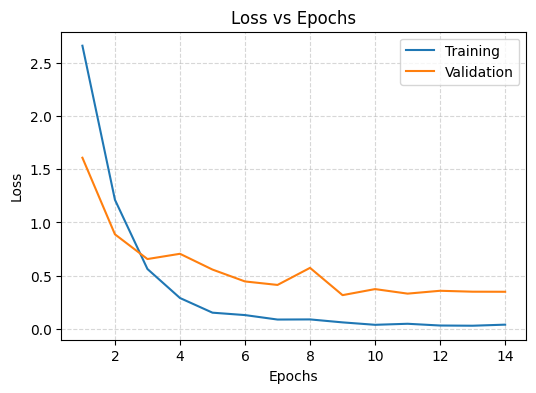

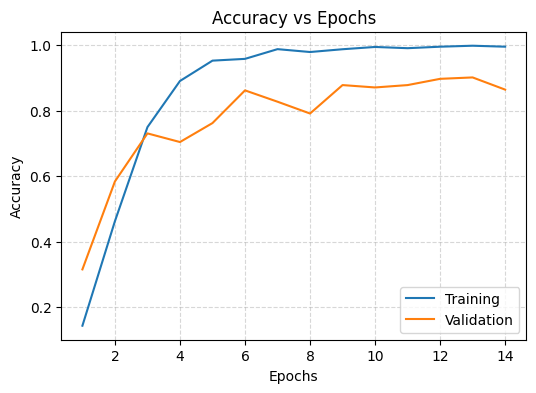

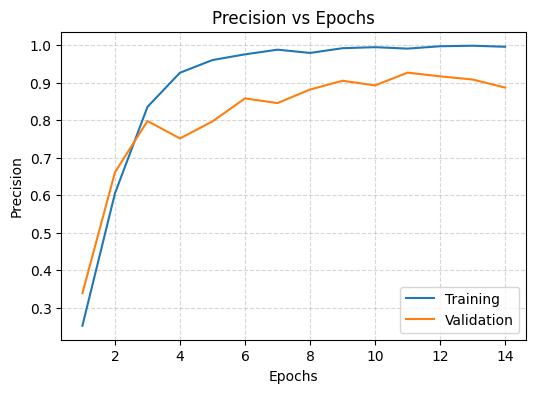

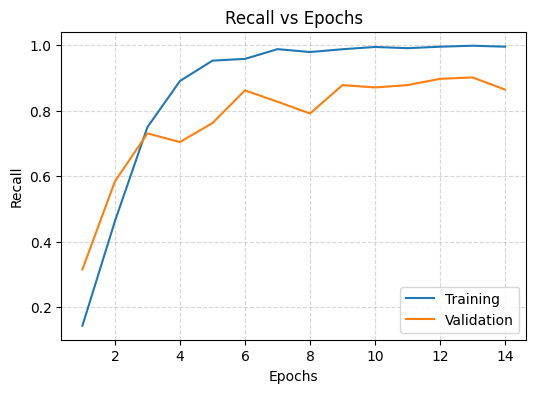

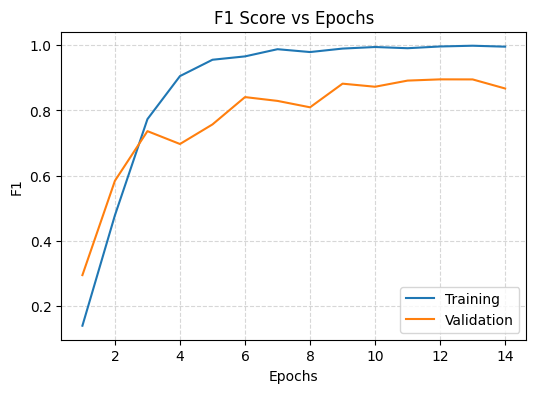

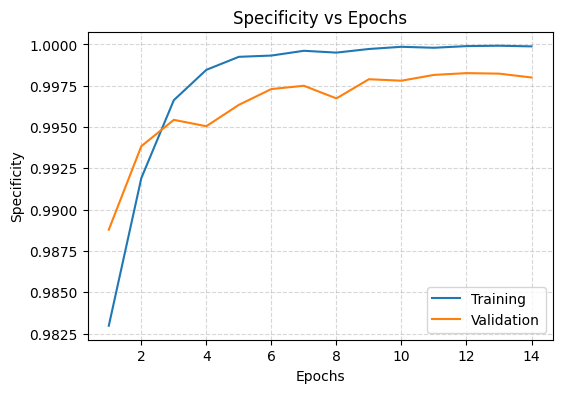

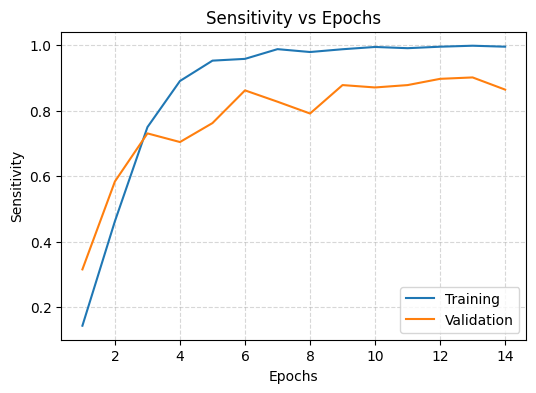

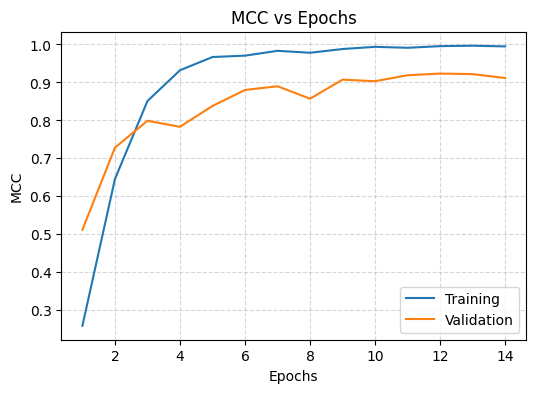

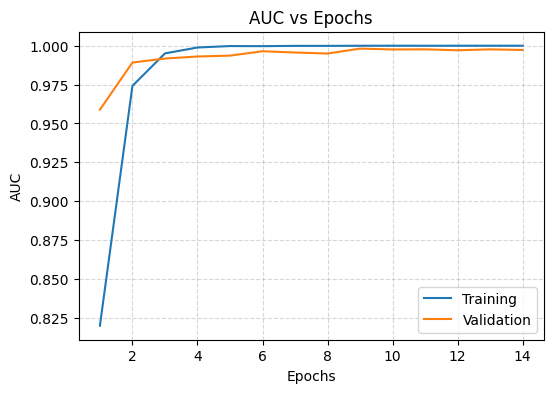

In [14]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [15]:
if os.path.exists("best_resnet50_44c.pth"):
    model.load_state_dict(torch.load("best_resnet50_44c.pth"))

    print("Best model loaded.")
else:
    print("No saved model found.")


Best model loaded.


In [16]:
# Load best model
torch.save(model.state_dict(), "best_resnet50_44c.pth")


model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [17]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 56/56 [00:06<00:00,  9.01it/s]



===== TEST RESULTS =====
Test Loss: 0.2999
ACC: 0.8716
PRECISION: 0.9280
RECALL: 0.8716
F1: 0.8888
AUC: 0.9979
MCC: 0.9096


In [18]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.8140    1.0000    0.8974        35
           1     0.8367    0.8913    0.8632        46
           2     0.9655    0.8235    0.8889        34
           3     1.0000    0.8462    0.9167        13
           4     0.9565    1.0000    0.9778        22
           5     1.0000    0.8667    0.9286        15
           6     0.8889    0.8889    0.8889         9
           7     0.7000    0.7000    0.7000        10
           8     0.8889    0.7273    0.8000        11
           9     1.0000    1.0000    1.0000         4
          10     1.0000    0.6667    0.8000         3
          11     1.0000    0.4000    0.5714         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    1.0000         8
          14     0.8750    1.0000    0.9333         7
          15     1.0000    0.8182    0.9000        11
          16     1.0000    0.9474    0.9730  

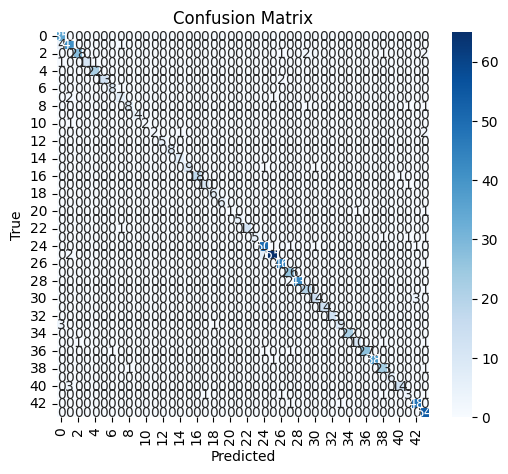

In [19]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


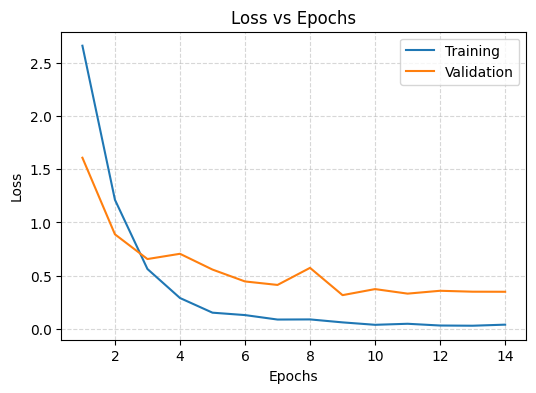

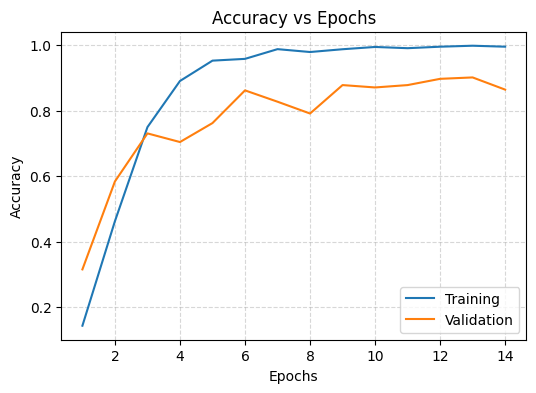

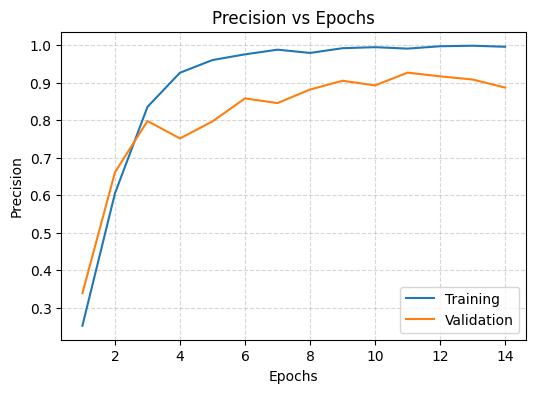

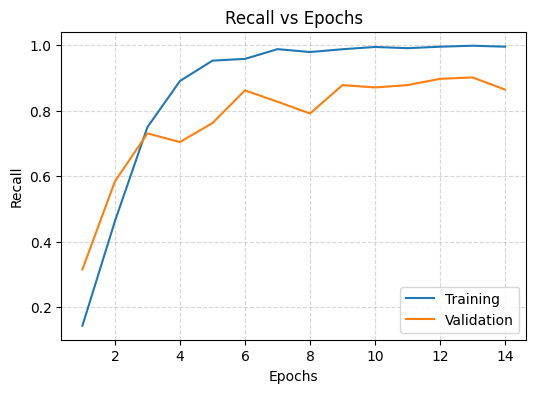

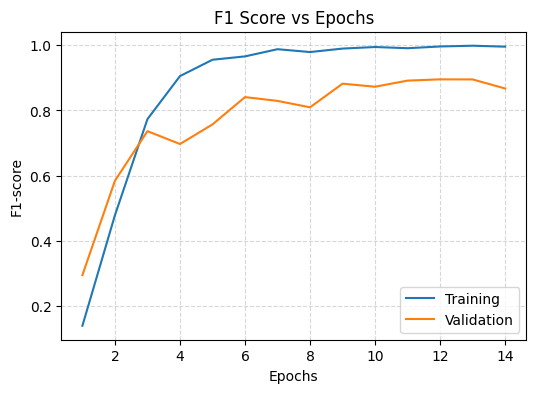

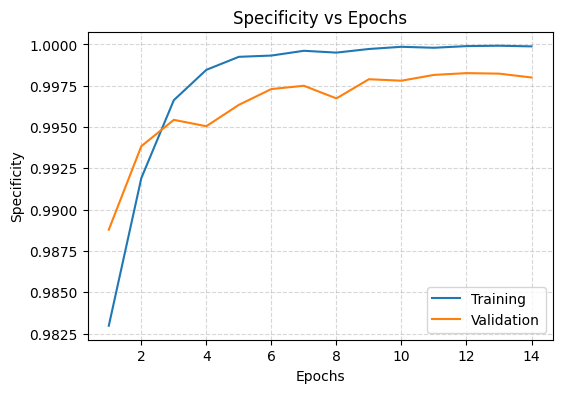

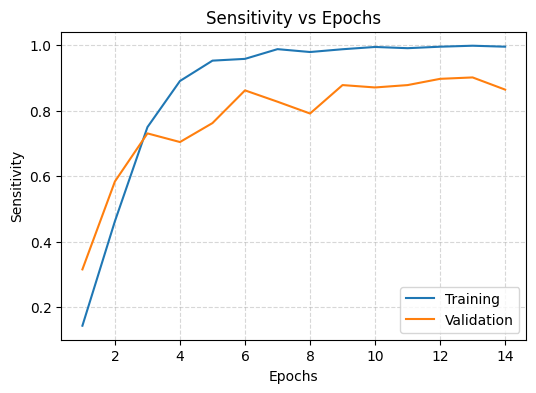

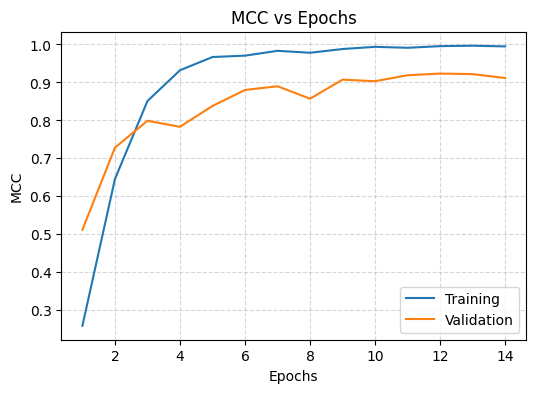

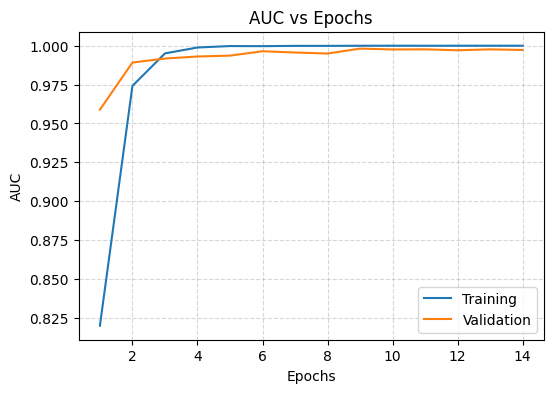

In [21]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
